In [1]:
import numpy as np
import nibabel.cifti2 as ci
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from joblib import Parallel, delayed
import pickle
# import graspy

from hyppo.time_series import MGCX

/home/ronak/.local/lib/python3.6/site-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


## Look At It

In [2]:
# Load image - individual 100307.
img = ci.load("rfMRI_REST1_LR_Atlas_hp2000_clean_filt_sm6.HCPMMP.ptseries.nii")
fmri_data = np.array(img.get_fdata())

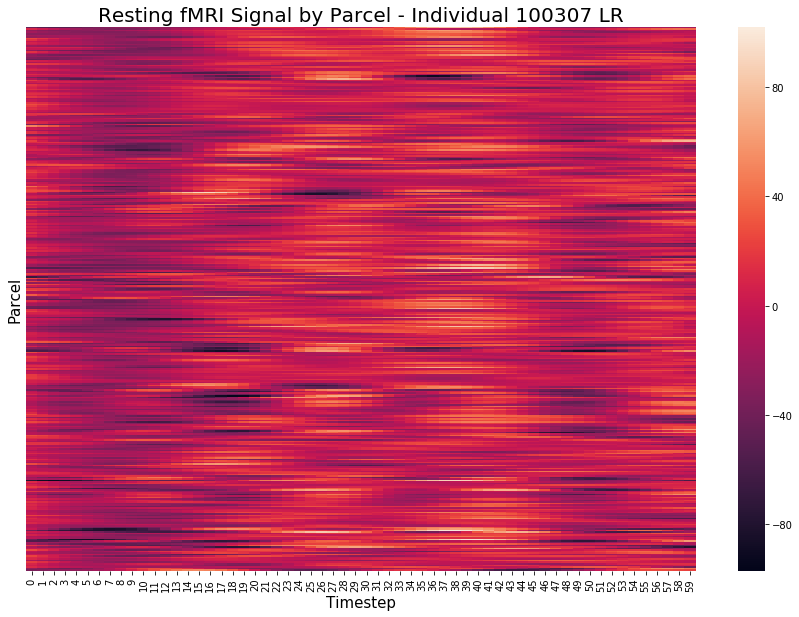

In [3]:
# Visualize data, i.e. inspect the first 60 timesteps of each parcel.

# Generate heatmap.
timesteps = 60
displayed_data = np.transpose(fmri_data[range(timesteps),:])
plt.subplots(figsize=(15,10))
ax = sns.heatmap(displayed_data, yticklabels=False)

# Plot parameters.
plt.title('Resting fMRI Signal by Parcel - Individual 100307 LR', fontsize = 20)
plt.ylabel('Parcel', fontsize = 15)
plt.xlabel('Timestep', fontsize = 15)
plt.show()

## Set Up Hyperparameters

In [4]:
# From Ting: Regions-of-Interest (ROIs)
roi_keys = np.array([1, 23, 18, 53, 24, 96, 117, 50, 143, 109, 148, 60, 38, 135, 93, 83, 149, 150, 65, 161, 132, 71]) - 1
roi_labels = np.array([
    "Visual",
    "Visual",
    "Visual",
    "Somatomoto",
    "Somatomoto",
    "dAtt",
    "dAtt",
    "dAtt",
    "dAtt",
    "vAtt",
    "vAtt",
    "vAtt",
    "vAtt",
    "Limbic",
    "Limbic",
    "FrontoParietal",
    "FrontoParietal",
    "DMN",
    "DMN",
    "DMN",
    "DMN",
    "DMN",
])

roi_data = fmri_data[0:300, roi_keys]
num_roi = len(roi_keys)

In [5]:
# Hyperparameters
max_lag = 1 # number of lags to check in the past
reps = 100 # number of bootstrap replicates
workers = 1 # number of workers in internal MGC parallelization

In [6]:
# Subsample to test experiment.
# pairs = list(product(range(num_roi), repeat = 2))
pairs = list(product(range(num_roi), repeat = 2))

## Run Experiment

In [7]:
mgcx = MGCX(max_lag = max_lag)

def worker(i, j):
    X = roi_data[:, i]
    Y = roi_data[:, j]
    
    stat, pval, mgcx_dict = mgcx.test(X, Y, reps = reps, workers = workers)
    opt_lag = mgcx_dict['opt_lag']
    opt_scale_x, opt_scale_y = mgcx_dict['opt_scale']
    
    return stat, pval, opt_lag, opt_scale_x, opt_scale_y

output = np.array(Parallel(n_jobs=-2)(delayed(worker)(i, j) for i, j in pairs))
pickle.dump(output, open('mgcx_fmri_output.pkl', 'wb'))

In [8]:
# Load results into num_roi-by-num_roi matrices.
results = pickle.load(open('mgcx_fmri_output.pkl', 'rb'))
test_stats = ["stat", "pval", "opt_lag", "opt_scale_x", "opt_scale_y"]

matrices = np.zeros((len(test_stats), num_roi, num_roi))
for p, pair in enumerate(pairs):
    i, j = pair
    for t, test_stat in enumerate(test_stats):
        matrices[t, i, j] = results[p, t]
        
for t, test_stat in enumerate(test_stats):
    pickle.dump(matrices[t], open('%s_matrix.pkl' % test_stat, 'wb'))

## Visualize Matrices

In [9]:
# def plot_heatmap(matrix, labels, title, filename):
#     sns.set()
#     cmap = mpl.cm.get_cmap('Purples')
#     center = 0
#     vmin = 0
#     vmax = 1
#     norm = mpl.colors.Normalize(0, 1)
#     cc = np.linspace(0.5, 1, 256)
#     cmap = mpl.colors.ListedColormap(cmap(cc))

#     heatmap_kws = dict(
#         cbar=True,
#         font_scale=1.4,
#         vmin=0,
#         vmax=1,
#         inner_hier_labels=labels,
#         hier_label_fontsize=20,
#         cmap=cmap,
#         center=None,
#     )
#     side_label_kws = dict(labelpad=45, fontsize=24)

#     fig, ax = plt.subplots(1, 1, figsize=(20, 16))

#     # SBM
#     heatmap(matrix, ax=ax, **heatmap_kws)
#     ax.set_title(title, pad = 100, fontdict = {'fontsize' : 23})

#     # Add colorbar
#     sm = plt.cm.ScalarMappable(cmap=cmap)
#     sm.set_array(data)
#     cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
#     cbar.ax.tick_params(labelsize=16)

#     plt.savefig(
#         "%s.pdf" % filename,
#         facecolor="w",
#         format="pdf",
#         bbox_inches="tight",
#     )

#     plt.tight_layout()
#     plt.show()

In [10]:
# titles = ["Test Statistic", "P-Value", "Optimal Lag", "Optimal Scale (X)", "Optimal Scale (Y)"]
# title = 'Test Statistic'
# filename = 'stat'
# for t, test_stat in enumerate(test_stats):
#     plot_heatmap(matrix, roi_labels, title, filename)